# COVID-19 vaccination in Poland

This notebook shows numbers of vaccineted population in Poland by communes (gminy).

### Dependencies:
- requests
- owslib
- pandas
- geopandas
- matplotlib

## Get vaccination data
source: www.gov.pl

### Get JSON from API

In [1]:
import requests

In [2]:
url = 'https://www.gov.pl/api/data/covid-vaccination-contest/results-details?segment=A,B,C'
response = requests.get(url)

if not response.ok:
    raise Exception(
        f'Error getting data. Reason: {response.reason}, code: {response.status_code}')

vacc_json = response.content

### Load into data frame

In [3]:
import pandas as pd

In [4]:
df = pd.read_json(vacc_json)
df.rename(columns={'teryt_code':'teryt'}, inplace=True)
df.sample(5)

,voivodeship,county,community,community_type,teryt,population,category,segment,full_vaccinated_amount,full_vaccinated_percent,overall_ranking_place,regional_ranking_place
1855,POMORSKIE,kwidzyński,Kwidzyn,2,2207032,11435,Elbląski,A,4770,41.7140,1856,1669
1166,MAZOWIECKIE,mławski,Lipowiec Kościelny,2,1413032,4805,Ciechanowski,A,2277,47.3881,1167,996
939,WIELKOPOLSKIE,ostrowski,Przygodzice,2,3017052,12232,Kaliski,A,5962,48.7410,940,777
928,KUJAWSKO-POMORSKIE,włocławski,Brześć Kujawski,3,418043,11352,Włocławski,A,5542,48.8196,929,768
1460,WIELKOPOLSKIE,śremski,Książ Wielkopolski,3,3026033,8471,Poznański,A,3852,45.4728,1461,1286


## Get vector data from WFS

In [5]:
import io
import requests
import geopandas as gpd

from functools import partial
from owslib.wfs import WebFeatureService


class GeoportalWFS:

    url = 'https://mapy.geoportal.gov.pl/wss/service/PZGIK/PRG/WFS/AdministrativeBoundaries'

    def __init__(self):
        self.wfs = WebFeatureService(url=self.url, version='2.0.0')

        for name in self.contents:
            method_name = 'get' + name[6:].lower()
            setattr(self, method_name, partial(
                self._wfs_to_geodataframe, name))

    def __repr__(self):
        return self.wfs.identification.title

    @classmethod
    def _make_query_url(cls, name, epsg=2180):

        params = dict(service='WFS', version='2.0.0', request='GetFeature',
                typeName=name, typeNames=name,
                srsName=f'urn:ogc:def:crs:EPSG::{epsg}')

        query_url = requests.Request('GET', cls.url, params=params).prepare().url

        return query_url

    @classmethod
    def _get_request_contents(cls, name):

        url = cls._make_query_url(name)
        r = requests.get(url)

        if not r.ok:
            raise Exception(
                f'Error getting geometry. Reason: {r.reason}, code: {r.status_code}')

        return io.BytesIO(r.content)

    @classmethod
    def _gml_to_geodataframe(cls, gml):
        return gpd.read_file(gml, driver='GML')

    @classmethod
    def _wfs_to_geodataframe(cls, name):
        gml = cls._get_request_contents(name)
        return cls._gml_to_geodataframe(gml)

    @property
    def contents(self):
        return list(self.wfs.contents)


In [6]:
gp = GeoportalWFS()

woj_geom = gp.get_granice_wojewodztw()
gminy_geom = gp.get_granice_gmin()

In [7]:
gminy_geom = gminy_geom[['JPT_KOD_JE', 'JPT_NAZWA_', 'geometry']].copy()
gminy_geom.columns = ['teryt', 'name', 'geometry']
gminy_geom['teryt'] = gminy_geom.teryt.astype(int)
gminy_geom

,teryt,name,geometry
0,608022,Abramów,"POLYGON ((725504.983 400474.510, 725519.731 40..."
1,608082,Michów,"MULTIPOLYGON (((737422.071 413700.575, 737418...."
2,609042,Garbów,"POLYGON ((737897.273 388650.140, 737916.436 38..."
3,609072,Jastków,"POLYGON ((741286.599 381096.132, 741327.903 38..."
4,608063,Kock,"POLYGON ((731811.808 419019.240, 731830.154 41..."
...,...,...,...
2472,3202023,Choszczno,"POLYGON ((259954.357 586599.189, 259975.070 58..."
2473,3202033,Drawno,"POLYGON ((284506.048 587587.505, 284519.441 58..."
2474,3212012,Bielice,"POLYGON ((218305.162 593773.844, 218383.394 59..."
2475,3212062,Warnice,"POLYGON ((233598.948 596617.358, 233604.733 59..."


## Merge tabular and spatial data

In [8]:
gminy = pd.merge(gminy_geom, df, how='left', on='teryt')
gminy = gminy[['voivodeship', 'county', 'community', 'community_type', 'teryt',
               'population', 'full_vaccinated_amount',	'full_vaccinated_percent', 'geometry']]
gminy

,voivodeship,county,community,community_type,teryt,population,full_vaccinated_amount,full_vaccinated_percent,geometry
0,LUBELSKIE,lubartowski,Abramów,2,608022,4029,1617,40.1340,"POLYGON ((725504.983 400474.510, 725519.731 40..."
1,LUBELSKIE,lubartowski,Michów,2,608082,5751,2323,40.3930,"MULTIPOLYGON (((737422.071 413700.575, 737418...."
2,LUBELSKIE,lubelski,Garbów,2,609042,9048,3696,40.8488,"POLYGON ((737897.273 388650.140, 737916.436 38..."
3,LUBELSKIE,lubelski,Jastków,2,609072,14351,7035,49.0210,"POLYGON ((741286.599 381096.132, 741327.903 38..."
4,LUBELSKIE,lubartowski,Kock,3,608063,6311,2026,32.1027,"POLYGON ((731811.808 419019.240, 731830.154 41..."
...,...,...,...,...,...,...,...,...,...
2472,ZACHODNIOPOMORSKIE,choszczeński,Choszczno,3,3202023,21529,11917,55.3532,"POLYGON ((259954.357 586599.189, 259975.070 58..."
2473,ZACHODNIOPOMORSKIE,choszczeński,Drawno,3,3202033,4993,2610,52.2732,"POLYGON ((284506.048 587587.505, 284519.441 58..."
2474,ZACHODNIOPOMORSKIE,pyrzycki,Bielice,2,3212012,3142,1628,51.8141,"POLYGON ((218305.162 593773.844, 218383.394 59..."
2475,ZACHODNIOPOMORSKIE,pyrzycki,Warnice,2,3212062,3443,1609,46.7325,"POLYGON ((233598.948 596617.358, 233604.733 59..."


## Display map

In [9]:
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime

Text(0.995, 0.99, 'as on 2021-11-28')

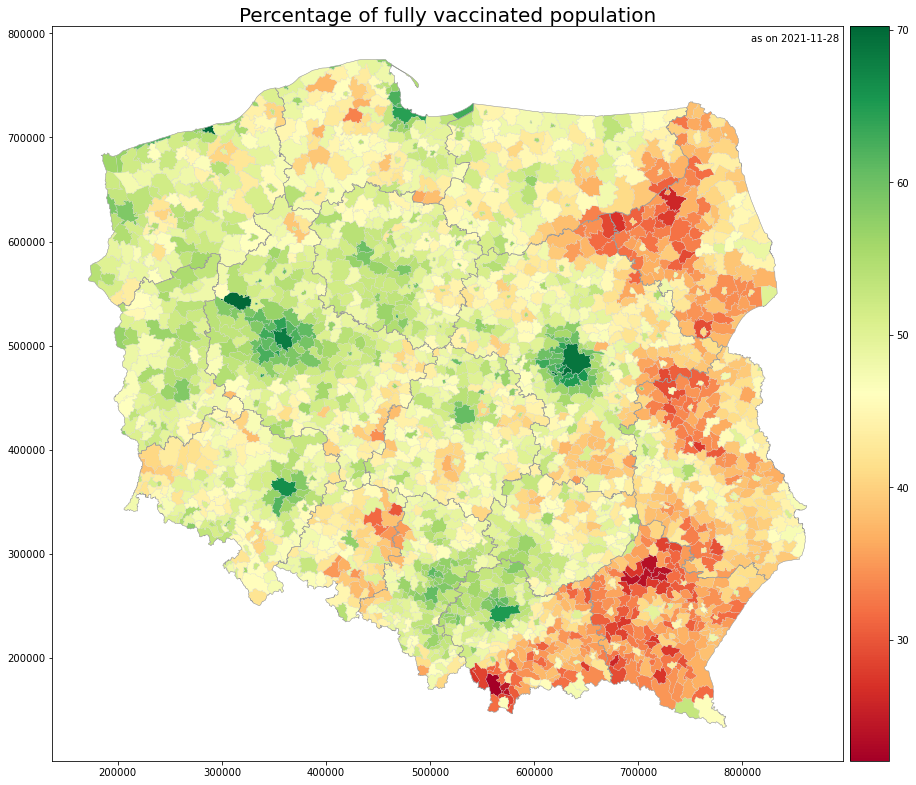

In [10]:
today = datetime.today().strftime("%Y-%m-%d")

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

gminy.plot(column='full_vaccinated_percent', ax=ax, cax=cax,
                  cmap='RdYlGn', legend=True,
                  edgecolor="lightgray", linewidth=0.2)

woj_geom.boundary.plot(ax=ax, edgecolor="#999999", linewidth=0.5)

plt.title('Percentage of fully vaccinated population',
                 fontdict={'fontsize':20},
                 pad=20,
                 ha="center",
                 transform=ax.transAxes)

txt_params = dict(ha="right", va="top", fontsize=10, transform=ax.transAxes)
plt.text(x=0.995, y=0.99, s=f'as on {today}', **txt_params)

### Save to shp [optional]

In [ ]:
# gminy.set_crs(epsg=2180, allow_override=True)
# gminy.to_file("gminy_vaccination.shp", encoding='utf-8')